In [113]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
from tqdm.auto import tqdm
import numpy as np
from datetime import date, timedelta
import time
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PowerTransformer,QuantileTransformer ,LabelEncoder, OneHotEncoder, MinMaxScaler, OrdinalEncoder, RobustScaler
import seaborn as sns
! pip install prince
import prince

! pip install optuna
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = '/content/drive/Shareddrives/dacon/Playground/'
train = pd.read_csv(path + 'train.csv', index_col=['id'])
test = pd.read_csv(path + 'test.csv', index_col=['id'])
submission = pd.read_csv(path + 'sample_submission.csv', index_col=['id'])

In [77]:
cat_features = [feature for feature in train.columns if 'cat' in feature]
cont_features = [feature for feature in train.columns if 'cont' in feature]

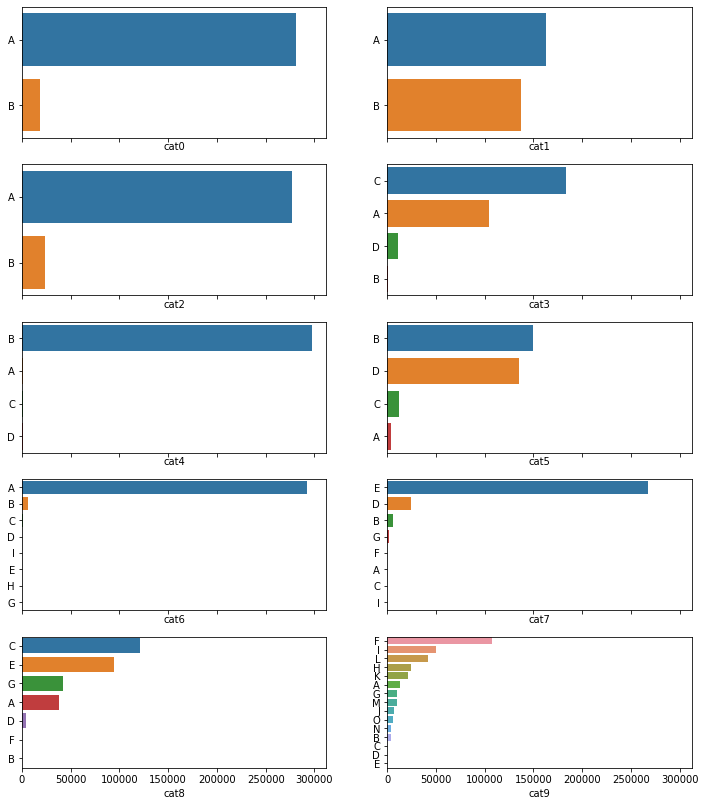

In [78]:
idx = 0
f, axes = plt.subplots(5,2,sharex = True, figsize = (12,14))

for row in range(5):
  for col in range(2):
    data = train[cat_features[idx]].value_counts()
    ax = sns.barplot(x = data.values, y =data.index, ax = axes[row, col])
    ax.set(xlabel = cat_features[idx])
    idx += 1

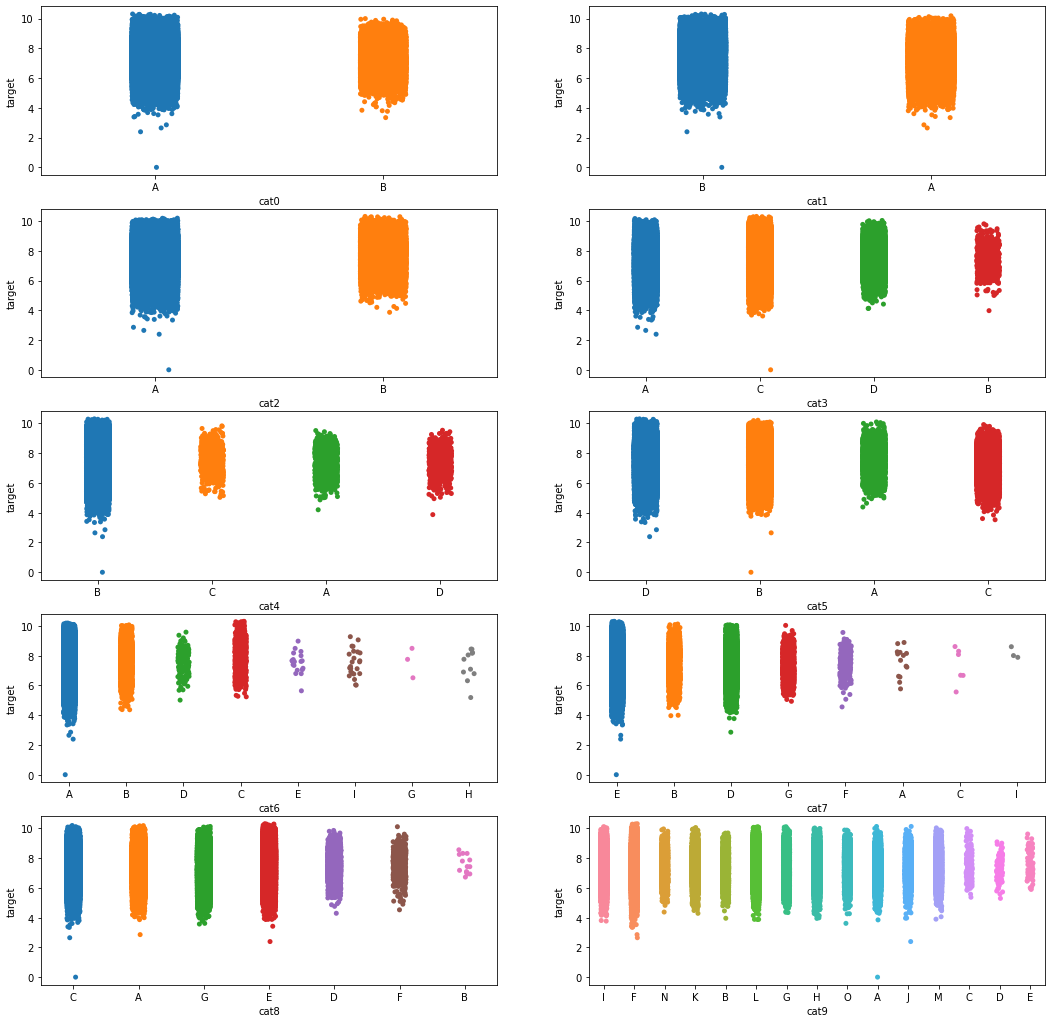

In [6]:
idx = 0
f, axes = plt.subplots(5,2, figsize = (18,18))

for row in range(5):
  for col in range(2):
    sns.stripplot(x = cat_features[idx], y = 'target', data = train, ax = axes[row, col])
    idx += 1

In [23]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

In [26]:
train

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
id,,,,,,,,,,,,,,,,,,,,,,,,,
1,A,B,A,A,B,D,A,E,C,I,0.923191,0.684968,0.124454,0.217886,0.281421,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903,6.994023
2,B,A,A,A,B,B,A,E,A,F,0.437627,0.014213,0.357438,0.846127,0.282354,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464,8.071256
3,A,A,A,C,B,D,A,B,C,N,0.732209,0.760122,0.454644,0.812990,0.293756,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352,5.760456
4,A,A,A,C,B,D,A,E,G,K,0.705142,0.771678,0.153735,0.732893,0.769785,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766,7.806457
6,A,B,A,A,B,B,A,E,C,F,0.486063,0.639349,0.496212,0.354186,0.279105,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743,6.868974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499993,A,B,A,C,B,B,A,E,E,L,0.260716,0.712438,0.161661,0.442794,0.768447,0.269578,0.258655,0.363598,0.300619,0.340516,0.235711,0.383477,0.215227,0.793630,8.343538
499996,A,B,A,C,B,B,A,E,E,L,0.173302,0.121591,0.592514,0.193711,0.775951,0.197211,0.257024,0.574304,0.227035,0.322583,0.286094,0.324874,0.306933,0.230902,7.851861
499997,A,B,A,C,B,B,A,E,C,M,0.342856,0.617869,0.462991,0.418098,0.297406,0.449482,0.386172,0.476217,0.135947,0.502730,0.235788,0.316671,0.250286,0.349041,7.600558


######### cat0 ############
2.878678917081735e-193
######### cat1 ############
0.0
######### cat2 ############
0.0
######### cat3 ############
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     A      B   0.0747 0.1608 -0.0177  0.1671  False
     A      C   0.1155  0.001  0.1067  0.1243   True
     A      D   0.0634  0.001  0.0407   0.086   True
     B      C   0.0408 0.6477 -0.0515  0.1331  False
     B      D  -0.0113    0.9 -0.1059  0.0833  False
     C      D  -0.0521  0.001 -0.0743 -0.0299   True
----------------------------------------------------


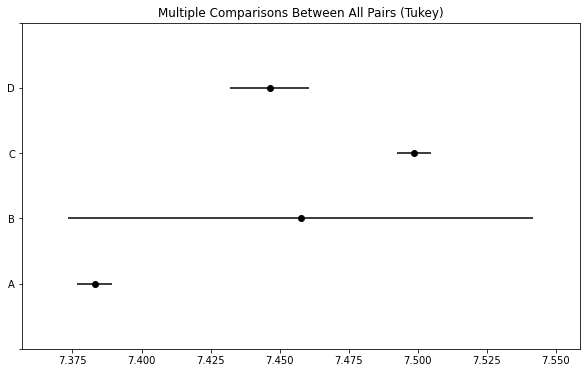

######### cat4 ############
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     A      B  -0.0094   0.9 -0.0742 0.0555  False
     A      C   0.2009 0.001  0.0962 0.3056   True
     A      D  -0.0292   0.9 -0.1414 0.0829  False
     B      C   0.2102 0.001  0.1278 0.2927   True
     B      D  -0.0199   0.9 -0.1116 0.0718  False
     C      D  -0.2301 0.001 -0.3533 -0.107   True
--------------------------------------------------


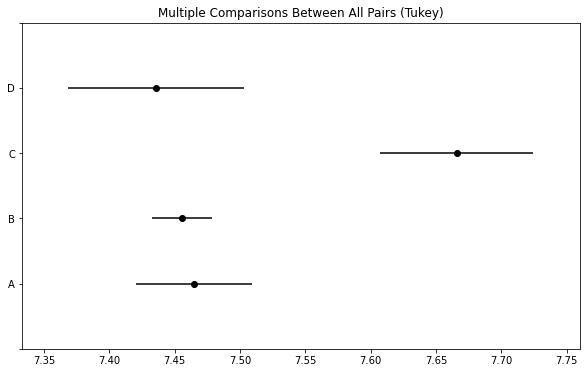

######### cat5 ############
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     A      B    0.022 0.4215  -0.015   0.059  False
     A      C  -0.2835  0.001 -0.3256 -0.2414   True
     A      D   0.0347 0.0765 -0.0024  0.0717  False
     B      C  -0.3055  0.001 -0.3273 -0.2837   True
     B      D   0.0126  0.001  0.0041  0.0212   True
     C      D   0.3181  0.001  0.2963    0.34   True
----------------------------------------------------


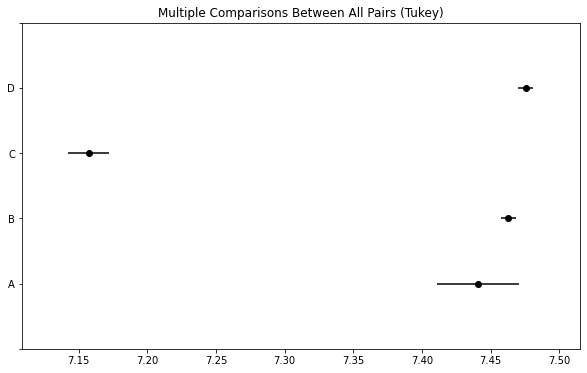

######### cat6 ############
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     A      B   0.3029  0.001  0.2688  0.3369   True
     A      C   0.5117  0.001  0.4171  0.6062   True
     A      D   0.1225 0.6777  -0.099   0.344  False
     A      E   0.0811    0.9 -0.5349  0.6971  False
     A      G   0.1377    0.9 -1.4124  1.6879  False
     A      H  -0.0545    0.9 -0.8641   0.755  False
     A      I   0.0609    0.9 -0.4872  0.6089  False
     B      C   0.2088  0.001  0.1086   0.309   True
     B      D  -0.1804 0.2216 -0.4044  0.0436  False
     B      E  -0.2218    0.9 -0.8386  0.3951  False
     B      G  -0.1651    0.9 -1.7156  1.3854  False
     B      H  -0.3574 0.8802 -1.1676  0.4528  False
     B      I   -0.242 0.8809 -0.7911  0.3071  False
     C      D  -0.3892  0.001 -0.6299 -0.1485   True
     C      E  -0.4306 0.4212 -1.0537  0.1926  False
     C      G  -0.

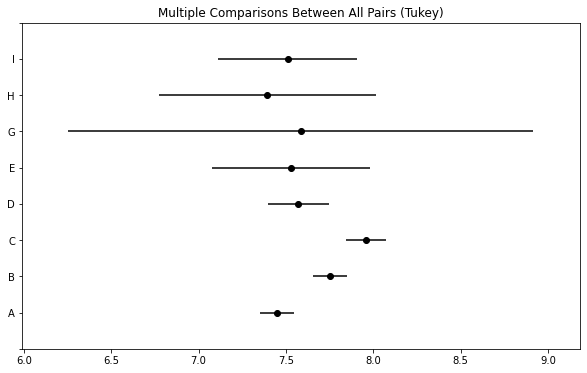

######### cat7 ############
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     A      B  -0.0717    0.9 -0.7912  0.6478  False
     A      C  -0.2411    0.9 -1.5532   1.071  False
     A      D  -0.0624    0.9 -0.7812  0.6565  False
     A      E  -0.1075    0.9 -0.8262  0.6112  False
     A      F  -0.0309    0.9 -0.7674  0.7055  False
     A      G  -0.1149    0.9 -0.8361  0.6063  False
     A      I    0.607    0.9 -1.1038  2.3177  False
     B      C  -0.1694    0.9 -1.2678  0.9289  False
     B      D   0.0093    0.9 -0.0301  0.0488  False
     B      E  -0.0358 0.0501 -0.0717     0.0  False
     B      F   0.0408    0.9 -0.1241  0.2056  False
     B      G  -0.0432  0.566 -0.1135  0.0271  False
     B      I   0.6787 0.8875 -0.8742  2.2316  False
     C      D   0.1788    0.9 -0.9192  1.2767  False
     C      E   0.1336    0.9 -0.9642  1.2314  False
     C      F   0.

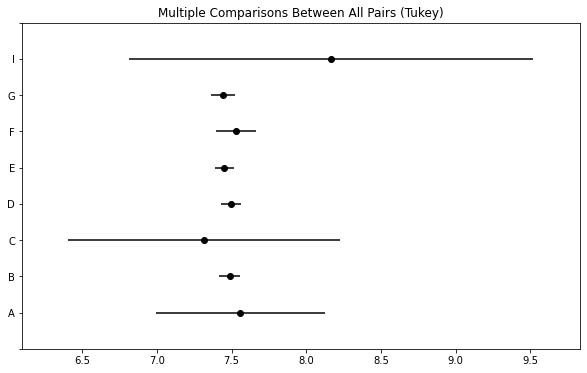

######### cat8 ############
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     A      B   0.0875    0.9 -0.6102  0.7851  False
     A      C  -0.0275  0.001 -0.0429 -0.0122   True
     A      D   0.0099    0.9 -0.0351  0.0549  False
     A      E   0.0406  0.001  0.0247  0.0565   True
     A      F   0.0519 0.7974 -0.0603  0.1641  False
     A      G  -0.1506  0.001 -0.1691 -0.1321   True
     B      C   -0.115    0.9 -0.8126  0.5826  False
     B      D  -0.0776    0.9 -0.7765  0.6213  False
     B      E  -0.0469    0.9 -0.7445  0.6507  False
     B      F  -0.0356    0.9 -0.7419  0.6708  False
     B      G  -0.2381    0.9 -0.9357  0.4596  False
     C      D   0.0374 0.1483 -0.0062   0.081  False
     C      E   0.0681  0.001  0.0568  0.0795   True
     C      F   0.0795 0.3542 -0.0322  0.1911  False
     C      G  -0.1231  0.001 -0.1378 -0.1083   True
     D      E   0.

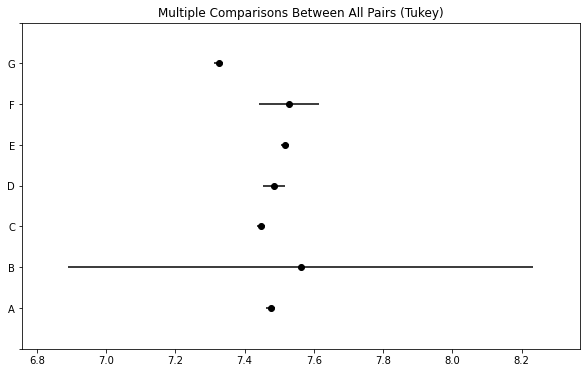

######### cat9 ############
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     A      B   0.0848  0.001  0.0276   0.142   True
     A      C   0.2756  0.001  0.0671  0.4841   True
     A      D   0.0441    0.9 -0.2517    0.34  False
     A      E   0.4074 0.0073  0.0564  0.7584   True
     A      F   0.1779  0.001  0.1505  0.2053   True
     A      G   0.2447  0.001  0.2056  0.2838   True
     A      H   0.1457  0.001  0.1137  0.1778   True
     A      I   0.0209 0.4875 -0.0082    0.05  False
     A      J   0.0431 0.0643  -0.001  0.0873  False
     A      K   0.0953  0.001  0.0622  0.1284   True
     A      L   0.3318  0.001  0.3021  0.3614   True
     A      M   0.1731  0.001  0.1334  0.2128   True
     A      N   0.1589  0.001  0.1056  0.2122   True
     A      O   0.1191  0.001  0.0731  0.1651   True
     B      C   0.1908 0.1389 -0.0223  0.4039  False
     B      D  -0.

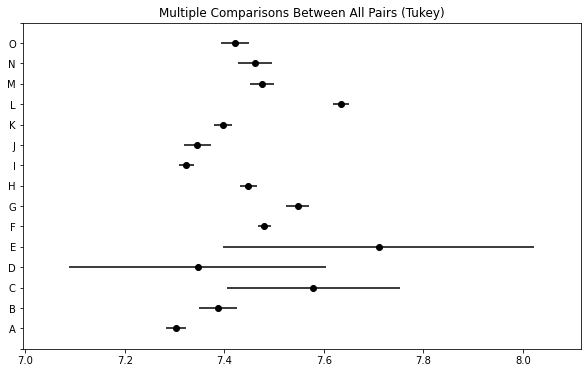

In [27]:
for cat in cat_features:
  uni = train[cat].unique()
  if len(uni) > 2:
    posthoc = pairwise_tukeyhsd(train['target'], train[cat], alpha = 0.05)
    print('#########', cat, '############')
    print(posthoc)
    fig = posthoc.plot_simultaneous()
    plt.show()
  elif len(uni) == 2:
    a = train.target[train[cat] == uni[0]]
    b = train.target[train[cat] == uni[1]]
    t, p = stats.ttest_ind(a,b)
    print('#########', cat, '############')
    print(p)

In [28]:
def create_stratified_folds_for_regression(data_df, n_splits=5):
    """
    @param data_df: training data to split in Stratified K Folds for a continous target value
    @param n_splits: number of splits
    @return: the training data with a column with kfold id
    """
    data_df['kfold'] = -1
    # randomize the data
    data_df = data_df.sample(frac=1, random_state=42).reset_index(drop=True)
    # calculate the optimal number of bins based on log2(data_df.shape[0])
    num_bins = np.int(np.floor(1 + np.log2(len(data_df))))
    # bins value will be the equivalent of class value of target feature used by StratifiedKFold to 
    # distribute evenly the classed over each fold
    data_df.loc[:, "bins"] = pd.cut(pd.to_numeric(data_df['target'], downcast="signed"), bins=num_bins, labels=False)
    kf = StratifiedKFold(n_splits=n_splits, random_state=42)
    
    # set the fold id as a new column in the train data
    for f, (t_, v_) in enumerate(kf.split(X=data_df, y=data_df.bins.values)):
        data_df.loc[v_, 'kfold'] = f
    
    # drop the bins column (no longer needed)
    data_df = data_df.drop("bins", axis=1)
    
    return data_df

In [159]:
def cv_evaluation_regression(df, model):
    n_fold = 5
    oof = np.zeros((len(df),))
    for fold in tqdm(range(n_fold)):
        val_ind = df[df.kfold == fold].index
        train = df[df.kfold != fold].reset_index(drop=True)
        valid = df[df.kfold == fold].reset_index(drop=True)

        features = [feature for feature in df.columns if feature not in ['id', 'target', 'kfold']]

        X_train = train[features]
        y_train = train['target']
        X_valid = valid[features]
        y_valid = valid['target']

        model.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], early_stopping_rounds = 500, verbose=False)
        preds = model.predict(valid[features])
        mse = mean_squared_error(y_valid, preds)
        
        oof[val_ind] = preds
    
    mse_oof = mean_squared_error(oof, df['target'])
    
    print(f'LGBM Overall RMSE:{np.sqrt(mse_oof)}')
    return mse_oof

In [143]:
train_data = train.iloc[:,:-1]
train_target = train.iloc[:, -1]
test_data = test.copy()

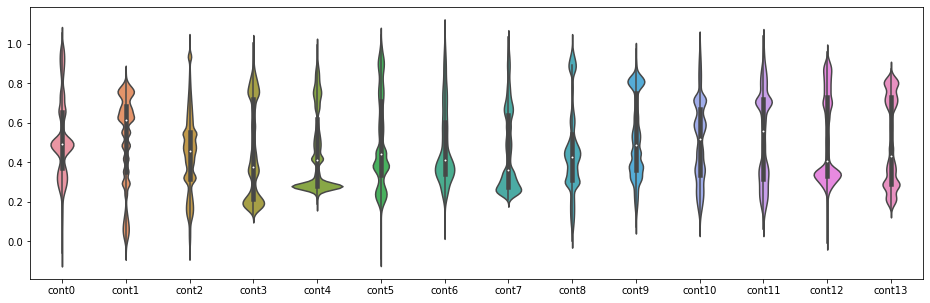

In [129]:
plt.figure(figsize=(16,5))
sns.violinplot(data = train_data[cont_features])

In [165]:
# # CAT4, CAT6 Drop하는 경우
# train_temp = train_data.drop(['cat6'], axis = 1)
# test_temp = test_data.drop(['cat6'], axis = 1)

train_temp = train_data.copy()
test_temp = test_data.copy()

cat_features = [feature for feature in train_temp.columns if 'cat' in feature]
cont_features = [feature for feature in train_temp.columns if 'cont' in feature]

# scaler  = QuantileTransformer(random_state=42, n_quantiles=2500)
scaler  = PowerTransformer()

a = pd.get_dummies(train_temp[cat_features])
b = pd.get_dummies(test_temp[cat_features])
missing_cols = set(a.columns) - set(b.columns)
for c in missing_cols:
  b[c] = 0
b = b[a.columns]

train_temp2 = train_data[cont_features]
test_temp2 = test_data[cont_features]
train_sc = scaler.fit_transform(train_temp2)
test_sc = scaler.transform(test_temp2)

train_scaled = pd.DataFrame(train_sc, index = train_temp2.index, columns = train_temp2.columns)
test_scaled = pd.DataFrame(test_sc, index = test_temp2.index, columns = test_temp2.columns)

trainset = pd.concat([train_scaled, a, train_target], axis = 1)
testset = pd.concat([test_scaled, b], axis = 1)

trainset.drop(['cat3_B', 'cat8_B'], axis = 1, inplace=True)

drops_cat5 = ['cat5_B', 'cat5_A', 'cat5_D']
trainset['cat5_ABD'] = trainset[drops_cat5].sum(axis = 1)
trainset.drop(drops_cat5, axis = 1, inplace=True)

drops_cat6 = ['cat6_E', 'cat6_I', 'cat6_H']
trainset['cat6_EIH'] = trainset[drops_cat6].sum(axis = 1)
trainset.drop(drops_cat6, axis = 1, inplace=True)


drops_cat7_1 = ['cat7_G', 'cat7_E']
trainset['cat7_GE'] = trainset[drops_cat7_1].sum(axis = 1)
drops_cat7_2 = ['cat7_B', 'cat7_D']
trainset['cat7_BD'] = trainset[drops_cat7_2].sum(axis = 1)
trainset.drop(drops_cat7_1, axis = 1, inplace=True)
trainset.drop(drops_cat7_2, axis = 1, inplace=True)

drops_cat8 = ['cat8_A', 'cat8_D']
trainset['cat8_AD'] = trainset[drops_cat8].sum(axis = 1)
trainset.drop(drops_cat8, axis = 1, inplace=True)


drops_cat9_1 = ['cat9_B', 'cat9_O', 'cat9_K']
trainset['cat9_BOK'] = trainset[drops_cat9_1].sum(axis = 1)
drops_cat9_2 = ['cat9_N', 'cat9_M', 'cat9_H']
trainset['cat9_NMH'] = trainset[drops_cat9_2].sum(axis = 1)
trainset.drop(drops_cat9_1, axis = 1, inplace=True)
trainset.drop(drops_cat9_2, axis = 1, inplace=True)

In [124]:
train_fold = create_stratified_folds_for_regression(trainset)
model = lgb.LGBMRegressor(random_state=42)
score = cv_evaluation_regression(train_fold, model)


LGBM Overall RMSE:0.8462646408680162


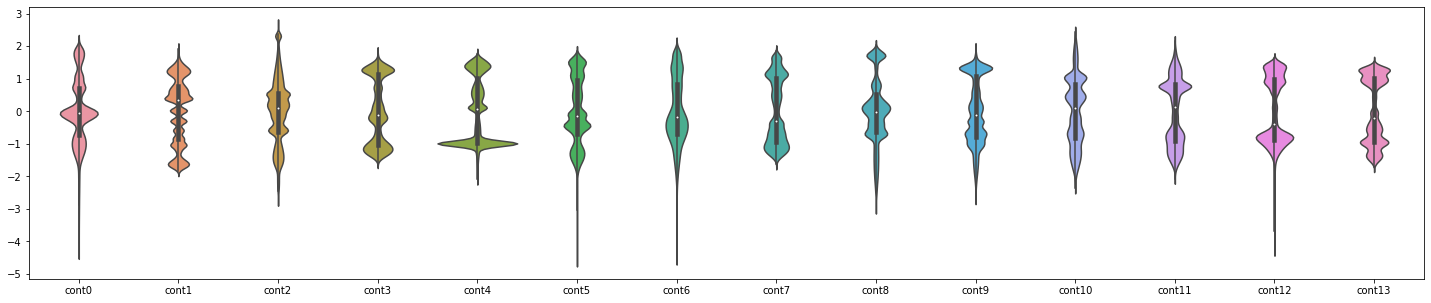

In [130]:
plt.figure(figsize=(25,5))
sns.violinplot(data = trainset[cont_features])

In [181]:
# Outlier 제거
trainset2 = trainset.copy()

from sklearn.ensemble import IsolationForest
model = IsolationForest(max_samples='auto', random_state=42, n_jobs = -1, contamination = 0.1, n_estimators=500)
model.fit(trainset2)

score = model.decision_function(trainset2)
anomaly = model.predict(trainset2)
trainset2['scores'] = score
trainset2['anomaly'] = anomaly

In [182]:
train_fold = create_stratified_folds_for_regression(trainset2)
model = lgb.LGBMRegressor(random_state=42)
score = cv_evaluation_regression(train_fold, model)


LGBM Overall RMSE:0.8449018263196459


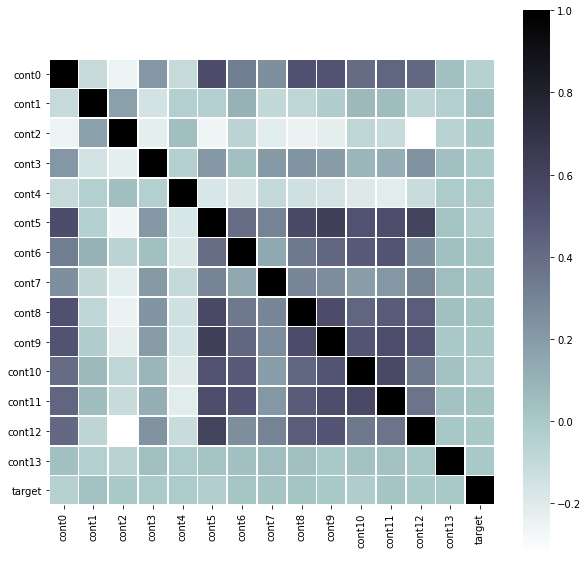

In [171]:
## 다중공선성 확인

plt.figure(figsize=(10,10))
sns.heatmap(trainset2[cont_features].join(train_target).corr(), square=True, linewidths=0.7, cmap="bone_r")

In [179]:
X = trainset2.loc[:, trainset2.columns != 'target']
X = X[cont_features]
y = trainset2['target']

In [180]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

### VIF 값이 10을 넘는 이상치 없음....... 그냥 쓰면 될 듯 하다.

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns 
vif

,VIF Factor,features
0,1.695632,cont0
1,1.085992,cont1
2,1.208957,cont2
3,1.141717,cont3
4,1.064631,cont4
5,2.390685,cont5
6,1.515827,cont6
7,1.182102,cont7
8,1.823751,cont8
9,2.078532,cont9
